# Joint flight data — first look

In [1]:
from setup   import *
from netCDF4 import Dataset
import glob

In [2]:
files = glob.glob("../data/*.nc")
halo_mw     = Dataset(glob.glob("../data/*nawd*mwr*.nc")[0],    "r")
halo_radar  = Dataset(glob.glob("../data/*nawd*cr*.nc")[0],     "r")
halo_sonde  = Dataset(glob.glob("../data/*nawd*sonde*.nc")[0],  "r")
rasta_radar = Dataset(glob.glob("../data/NAWDEX*RASTA*.nc")[0], "r")

### HALO Sondes


In [108]:
halo_sonde.variables['sonde_number'][:]
sonde_lat = halo_sonde.variables["lat"][:]
sonde_lon = halo_sonde.variables["lon"][:]
sonde_z   = halo_sonde.variables["height"][:]
sonde_p   = halo_sonde.variables["pa"][:]
sonde_rh  = halo_sonde.variables["hur"][:]

/home/simon/src/matplotlib/lib/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


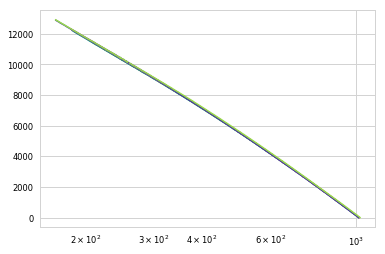

In [113]:
plt.plot(sonde_p.T, sonde_z.T)
plt.xscale("log")

### HAMP RADAR data

For the HALO aircraft, the joined leg of the flight campaign lasted from 9:51 to 10:16 UTC. Here we extract the start and end time of the leg in seconds passed sind the reference data first of January 1970.

In [70]:
from datetime import datetime

t0 = datetime(year = 1970, month = 1, day = 1, hour = 0, minute = 0, second = 0)
t1 = datetime(year = 2016, month = 10, day = 14, hour = 9, minute = 51, second = 30)
t2 = datetime(year = 2016, month = 10, day = 14, hour = 10, minute = 15, second = 30)

dt_start = (t1 - t0).total_seconds()
dt_end   = (t2 - t0).total_seconds()

In [115]:
halo_times = halo_radar["time"][:]
i_start = np.where(halo_times >= dt_start)[0][0]
i_end   = np.where(halo_times >  dt_end)[0][0]

hamp_dbz = halo_radar["dbz"][i_start : i_end]
hamp_lat = halo_radar["lat"][i_start : i_end]
hamp_lon = halo_radar["lon"][i_start : i_end]
hamp_z   = halo_radar.variables["height"]

### Rasta data
For the Falcon aircraft, the time is given in hours since midnight so determining the start and end points of the joint flight is simpler.

In [ ]:
rasta_

In [72]:
from datetime import datetime

t_start = 9  + 50 / 60
t_end   = 10 + 21 / 60

In [135]:
rasta_times = rasta_radar["time"][:]
i_start = np.where(rasta_times >= t_start)[0][0]
i_end   = np.where(rasta_times >  t_end)[0][0]

rasta_dbz = rasta_radar["Z"][i_start : i_end, :]
rasta_lat = rasta_radar["latitude"][i_start : i_end]
rasta_lon = rasta_radar["longitude"][i_start : i_end]
altitude  = rasta_radar.variables["altitude"][i_start : i_end]
rasta_z   = altitude.reshape(-1, 1) - rasta_radar.variables["range"][:].reshape(1, -1)

In [142]:
rasta_radar.variables["range"][:].reshape(1, -1)

array([[ 0.015,  0.075,  0.135,  0.195,  0.255,  0.315,  0.375,  0.435,
         0.495,  0.555,  0.615,  0.675,  0.735,  0.795,  0.855,  0.915,
         0.975,  1.035,  1.095,  1.155,  1.215,  1.275,  1.335,  1.395,
         1.455,  1.515,  1.575,  1.635,  1.695,  1.755,  1.815,  1.875,
         1.935,  1.995,  2.055,  2.115,  2.175,  2.235,  2.295,  2.355,
         2.415,  2.475,  2.535,  2.595,  2.655,  2.715,  2.775,  2.835,
         2.895,  2.955,  3.015,  3.075,  3.135,  3.195,  3.255,  3.315,
         3.375,  3.435,  3.495,  3.555,  3.615,  3.675,  3.735,  3.795,
         3.855,  3.915,  3.975,  4.035,  4.095,  4.155,  4.215,  4.275,
         4.335,  4.395,  4.455,  4.515,  4.575,  4.635,  4.695,  4.755,
         4.815,  4.875,  4.935,  4.995,  5.055,  5.115,  5.175,  5.235,
         5.295,  5.355,  5.415,  5.475,  5.535,  5.595,  5.655,  5.715,
         5.775,  5.835,  5.895,  5.955,  6.015,  6.075,  6.135,  6.195,
         6.255,  6.315,  6.375,  6.435,  6.495,  6.555,  6.615, 

In [127]:
rasta_radar.variables["altitude"]

<class 'netCDF4._netCDF4.Variable'>
float32 altitude(time)
    units: km
    long_name: Height of the aircraft above geoid
    missing_value: -999.0
    comments: from Global Positioning System (GPS)
unlimited dimensions: time
current shape = (11924,)
filling on, default _FillValue of 9.969209968386869e+36 used

In [122]:
rasta_radar.variables

OrderedDict([('range', <class 'netCDF4._netCDF4.Variable'>
              float32 range(range)
                  units: km
                  long_name: Range from the radar to the centre of each range gate
              unlimited dimensions: 
              current shape = (250,)
              filling on, default _FillValue of 9.969209968386869e+36 used),
             ('time', <class 'netCDF4._netCDF4.Variable'>
              float32 time(time)
                  units: hours UTC
                  long_name: Decimal hours UTC since midnight
                  missing_value: -999.0
              unlimited dimensions: time
              current shape = (11924,)
              filling on, default _FillValue of 9.969209968386869e+36 used),
             ('latitude', <class 'netCDF4._netCDF4.Variable'>
              float32 latitude(time)
                  units: degrees north
                  long_name: Latitude of the aircraft
                  missing_value: -999.0
                  comments:

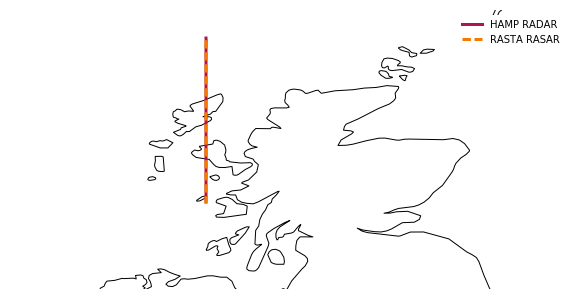

In [81]:
import cartopy.crs as ccrs
fig = plt.figure(figsize = (10, 10))
ax  = fig.add_subplot(1, 1, 1, projection = ccrs.PlateCarree())

ax.plot(hamp_lon, hamp_lat, label = "HAMP RADAR", lw = 3)
ax.plot(rasta_lon, rasta_lat, label = "RASTA RASAR", lw = 3, ls = "--")

ax.coastlines(resolution = "50m", linewidth = 1)
ax.set_xlim([-10, -0])
ax.set_ylim([55, 60])
ax.legend()

In [ ]:
TTTTTTTTTTTTTT

array([[11.166939 , 11.106939 , 11.046939 , ..., -3.653061 , -3.7130613,
        -3.7730608],
       [11.165781 , 11.105782 , 11.045781 , ..., -3.6542187, -3.714219 ,
        -3.7742186],
       [11.1646385, 11.104639 , 11.044639 , ..., -3.6553612, -3.7153616,
        -3.775361 ],
       ...,
       [11.131625 , 11.071626 , 11.011625 , ..., -3.6883745, -3.748375 ,
        -3.8083744],
       [11.131381 , 11.071382 , 11.011381 , ..., -3.6886187, -3.748619 ,
        -3.8086185],
       [11.131152 , 11.071153 , 11.011152 , ..., -3.6888475, -3.748848 ,
        -3.8088474]], dtype=float32)

(0, 10)

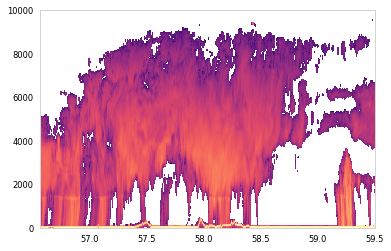

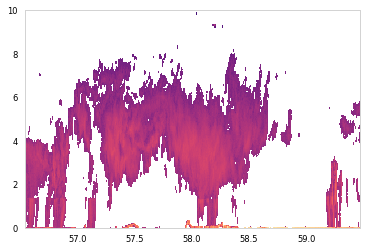

In [148]:
plt.pcolormesh(hamp_lat, hamp_z, hamp_dbz.T)
plt.ylim([0, 10e3])
plt.figure()
plt.pcolormesh(np.broadcast_to(rasta_lat.reshape(-1, 1), (rasta_z.shape)),
                rasta_z, rasta_dbz[:, ::-1])
plt.ylim([0, 10])

In [13]:
halo_sonde.variables

OrderedDict([('sonde_number', <class 'netCDF4._netCDF4.Variable'>
              float64 sonde_number(sonde_number)
                  long_name: sonde number
                  comments: none
                  units: 
              unlimited dimensions: 
              current shape = (7,)
              filling on, default _FillValue of 9.969209968386869e+36 used),
             ('height', <class 'netCDF4._netCDF4.Variable'>
              float64 height(height)
                  standard_name: height
                  long_name: height above mean sea level
                  comments: none
                  units: m
              unlimited dimensions: 
              current shape = (461,)
              filling on, default _FillValue of 9.969209968386869e+36 used),
             ('wdir', <class 'netCDF4._netCDF4.Variable'>
              float64 wdir(sonde_number, height)
                  _FillValue: -999.0
                  standard_name: dir
                  long_name: wdir sondes
        